# Задача 1. Линейная регрессия, метод градиентного спуска

Задачу выполнил Степырев Даниил, студент 22.М-05мм группы.

## Данные, на которых решается задача

В задаче используется датасет электрических машин (ссылка).
Описание датасета:
- **Brand** --- марка автомобиля
- **Model** --- название модели автомобиля
- **AccelSec** --- время ускорения автомобиля 0-100 км/ч в секундах
- **TopSpeed_KmH** --- максимальная скорость в км/ч
- **Range_Km** --- запас хода в километрах
- **Efficiency_WhKm** --- эффективность (?)
- **FastCharge_KmH** --- скорость зарядки автомобиля: число добавленных километров в час
- **RapidCharge** --- возможность быстрой зарядки
- **PowerTrain** --- привод автомобиля
- **PlugType** --- тип зарядки
- **BodyStyle** --- тип кузова
- **Segment** --- класс автомобиля
- **Seats** --- количество пассажирских мест
- **PriceEuro** --- цена в евро

## Считывание данных

Подключаем используемые библиотеки:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [2]:
df = pd.read_csv('Dataset/electric-cars.csv')

Считываем обучающую выборку:

In [3]:
df.head()

,Brand,Model,Accel,TopSpeed,Range,Efficiency,FastCharge,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6 sec,233 km/h,450 km,161 Wh/km,940 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0 sec,160 km/h,270 km,167 Wh/km,250 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7 sec,210 km/h,400 km,181 Wh/km,620 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8 sec,180 km/h,360 km,206 Wh/km,560 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5 sec,145 km/h,170 km,168 Wh/km,190 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,B,4,32997


Общее количество пропущенных значений:

In [4]:
df.isnull().sum()

Brand          0
Model          0
Accel          0
TopSpeed       0
Range          0
Efficiency     0
FastCharge     0
RapidCharge    0
PowerTrain     0
PlugType       0
BodyStyle      0
Segment        0
Seats          0
PriceEuro      0
dtype: int64

Все признаки имеют заполненные значения значения.

Рассмотрим, какого тип признаков проставлен в датасете по умолчанию:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Brand        103 non-null    object
 1   Model        103 non-null    object
 2   Accel        103 non-null    object
 3   TopSpeed     103 non-null    object
 4   Range        103 non-null    object
 5   Efficiency   103 non-null    object
 6   FastCharge   103 non-null    object
 7   RapidCharge  103 non-null    object
 8   PowerTrain   103 non-null    object
 9   PlugType     103 non-null    object
 10  BodyStyle    103 non-null    object
 11  Segment      103 non-null    object
 12  Seats        103 non-null    int64 
 13  PriceEuro    103 non-null    int64 
dtypes: int64(2), object(12)
memory usage: 11.4+ KB


Рассмотрим статистику по целевому признаку **PriceEuro**: сколько и каких значений он принимает. Воспользуемся функцией value_counts(): 

In [6]:
df['PriceEuro'].value_counts()

45000    6
50000    3
29234    2
30000    2
36837    2
        ..
38105    1
67358    1
34361    1
38017    1
62000    1
Name: PriceEuro, Length: 87, dtype: int64

Видим, что **PriceEuro** принимает 87 различных значений. Посчитаем минимальную, максимальную и среднюю цену:

In [7]:
df['PriceEuro'].min()

20129

In [8]:
df['PriceEuro'].max()

215000

In [9]:
df['PriceEuro'].mean()

55811.5631

Выяснили, что поле **PriceEuro** принимает значения от 20129 до 215000. Средняя цена электромобиля: 55811.

## Первичный анализ данных

### Признак Brand

Выясним, какой тип имеет признак **Марка** в датасете:

In [10]:
df['Brand'].describe()

count        103
unique        33
top       Tesla 
freq          13
Name: Brand, dtype: object

Видим, что признак **Марка** принимает 33 уникальных значения. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только строковые значения. Уточним тип этого признака:

In [11]:
df['Brand'] = df['Brand'].astype('|S').apply(lambda s: s.strip())
df['Brand'].describe()

count          103
unique          33
top       b'Tesla'
freq            13
Name: Brand, dtype: object

Выясним, сколько электрических автомобилей доступно у определённой **марки**. Отобразим эти значения на графике:

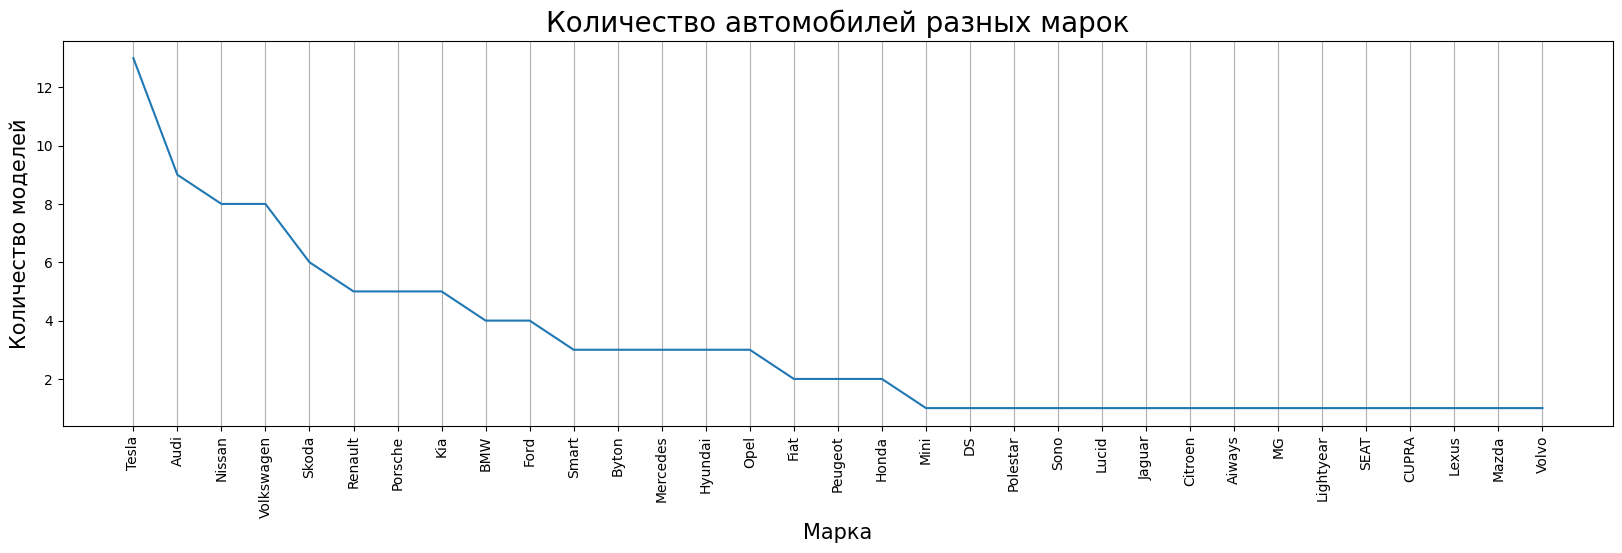

In [12]:
plt.figure(figsize=(20,5))
plt.grid(axis="x")
plt.xticks(rotation = 90)
plt.title('Количество автомобилей разных марок', fontsize = 20)
plt.xlabel('Марка', fontsize= 15)
plt.ylabel('Количество моделей', fontsize= 15)
plt.plot(df["Brand"].value_counts())
plt.show()

Видим, что в датасете представлено больше всего электромобилей марки *Tesla*, *Audi* и *Nissan*. Марки *Mini*, *DS*, *Polestar*, *Sono*, *Lucid*, *Jaguar*, *Citroern*, *Aiways*, *MG*, *Lightyear*, *SEAT*, *CUPRA*, *Lexus*, *Mazda*, *Volvo* имеют в датасете всего по одной представленной модели.

Посмотрим график стоимости автомобиля *PriceEuro* в зависимости от марки:

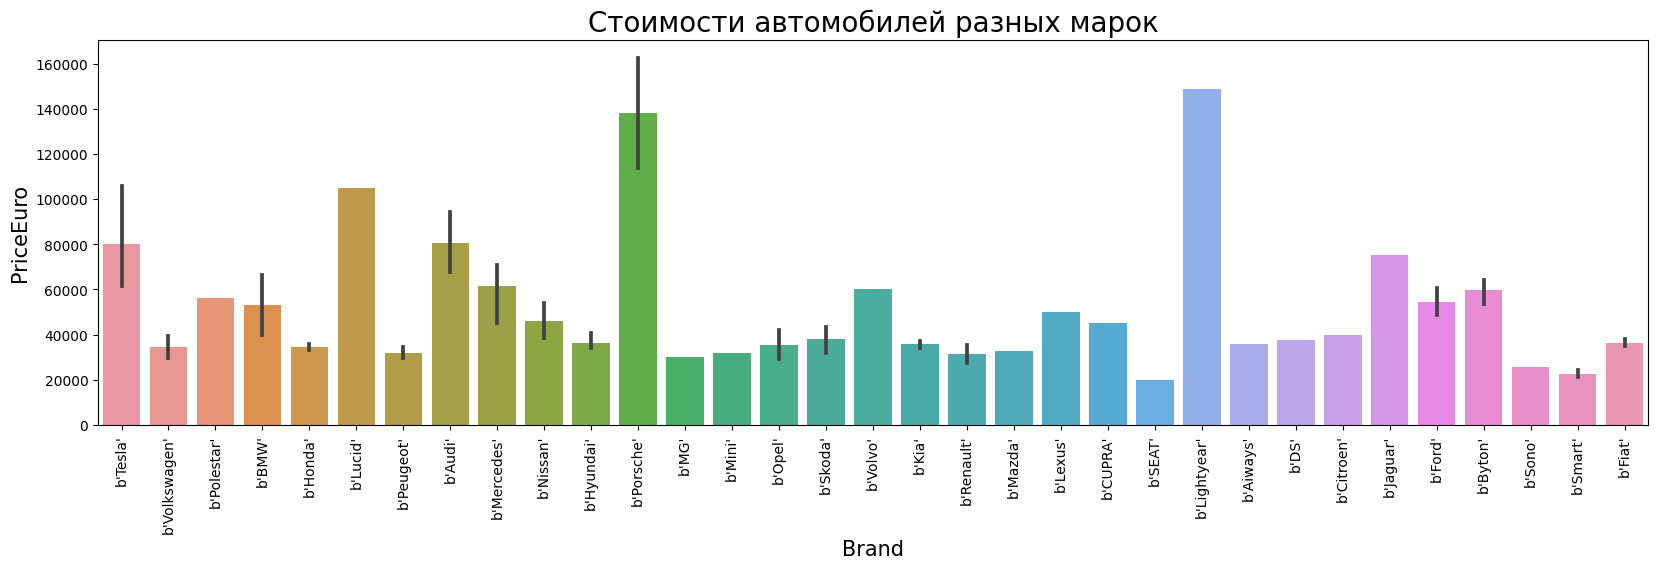

In [13]:
plt.figure(figsize=(20,5))
plt.grid(axis="x")
plt.xticks(rotation = 90)
plt.title('Стоимости автомобилей разных марок', fontsize = 20)
plt.xlabel('Марка', fontsize= 15)
plt.ylabel('Цена автомобиля в евро', fontsize= 15)
sns.barplot(x = df["Brand"], y = df["PriceEuro"])
plt.show()

Из графика видно, что большинство автомобилей в датасете стоят от 40000 до 60000 евро. Самые дорогие автомобили у марок *Porsche* и *Lightyear*, а самые бюджетные у *SEAT* и *Smart*.

### Признак Model

Выясним, сколько стоят автомобиля определённой **модели**. Отобразим эти значения на графике:

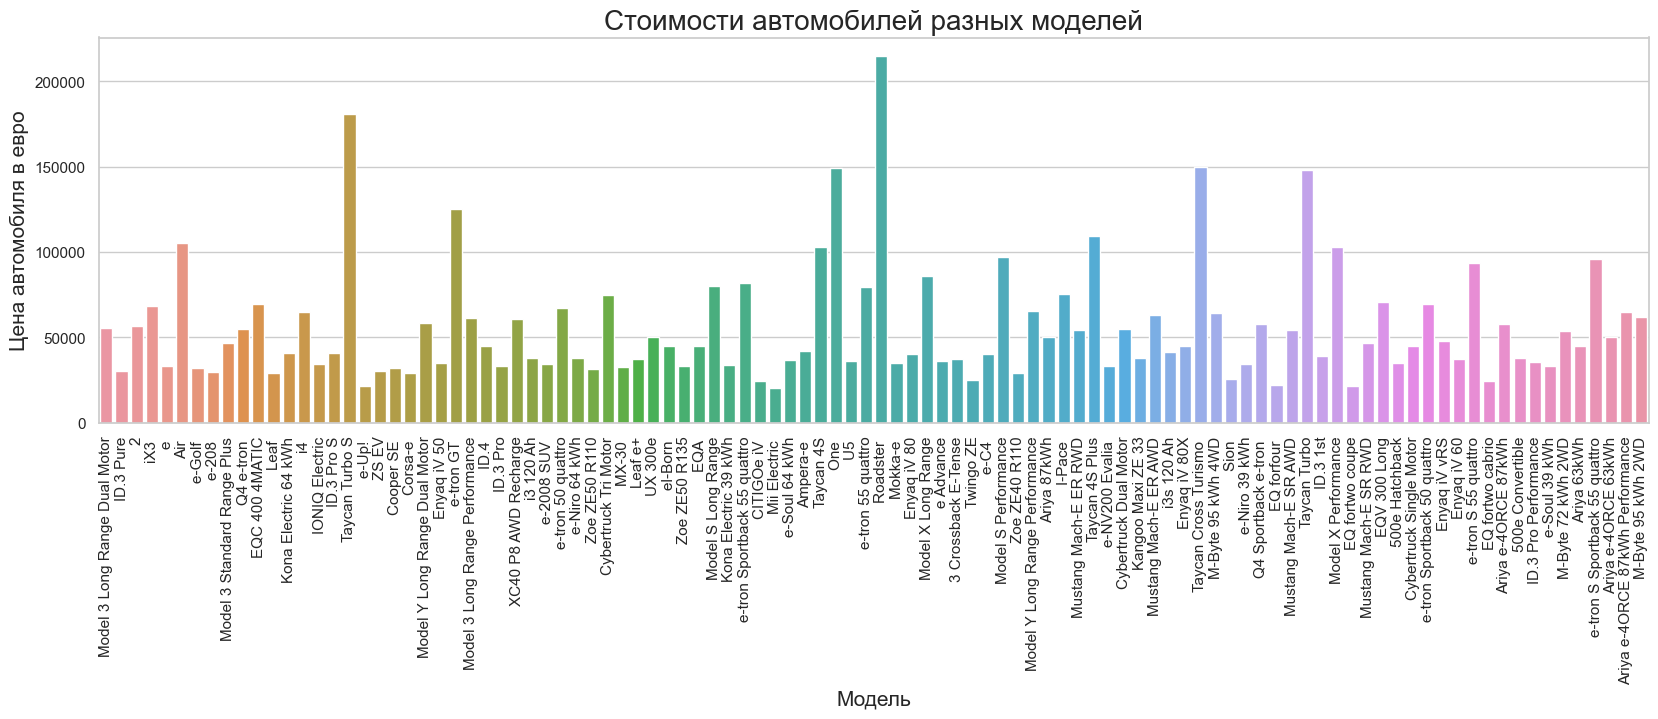

In [14]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "Model", y = "PriceEuro", data = df)
plt.title('Стоимости автомобилей разных моделей', fontsize = 20)
plt.ylabel('Цена автомобиля в евро', fontsize= 15)
plt.xlabel('Модель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Видим более подробное график цен автомобилей и их стоимости. Из графика видно, что электических автомобили можно разделить по стоимости на две группы: дешевле 50000 евро и дороже 50000 евро.

Также можно заметить, что признак **Model** и признак **Brand** имеют много уникальных значений. На ценообразование машины может влиять страна, в которой автомобиль был разработан. Для определения страны производителя, напишем небольшую функцию `get_origin_country(brand)`:

In [15]:
def get_origin_country(brand):
    if (brand == b'Mercedes' or brand == b"Porsche" or brand == b"Mini"
       or brand == b"Volkswagen" or brand == b"BMW" or brand == b"Audi"
       or brand == b"Opel" or brand == b"Sono" or brand == b"Smart"):
        return "Germany"
    
    if (brand == b"Peugeot" or brand == b"Nissan" or brand == b"Renault"
       or brand == b"DS" or brand == b"Citroen"):
        return "France"
    
    if (brand == b"Honda" or brand == b"Mazda" or brand == b"Lexus"):
        return "Japan"
    
    if (brand == b"Tesla" or brand == b"Lucid" or brand == b"Ford"):
        return "USA"
    
    if (brand == b"Polestar" or brand == b"Volvo"):
        return "Sweden"

    if (brand == b"Hyundai" or brand == b"Kia"):
        return "Korea"
    
    if (brand == b"CUPRA" or brand == b"SEAT"):
        return "Spain"
    
    if (brand == b"MG" or brand == b"Jaguar"):
        return "England"
    
    if (brand == b"Aiways" or brand == b"Byton"):
        return "China"

    if (brand == b"Lightyear"):
        return "Finland"    
    
    if (brand == b"Skoda"):
        return "Czech"
    
    if (brand == b"Fiat"):
        return "Italy"
    
    return "Other"

Введём новый признак **OriginCountry** и проверим это предположение:

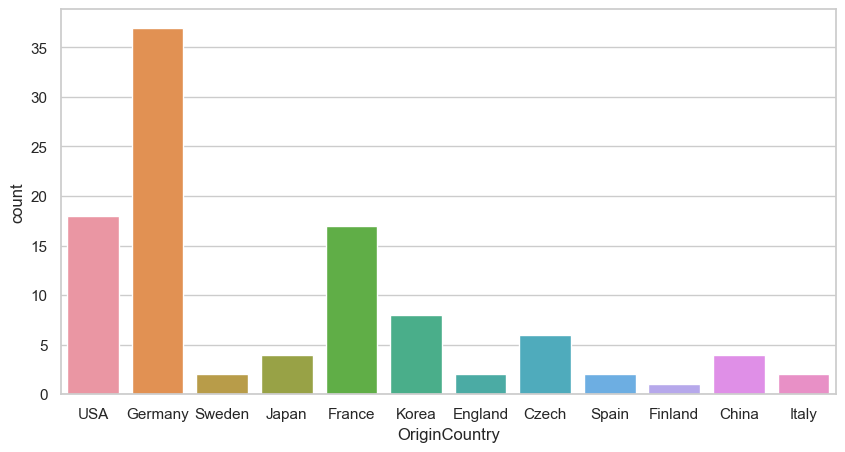

In [16]:
df['OriginCountry'] = df['Brand'].apply(lambda x: get_origin_country(x))
sns.countplot(x=df['OriginCountry'])
fig = plt.gcf()
fig.set_size_inches(10, 5)

Видим, что удалось распределить все автомобили по странам производителям. Больше всего автомобилей имеют страну производителя Германию, США и Францию, меньше всего --- Финляндию.

Рассмотрим график стоимости автомобиля относительно страны производителя:

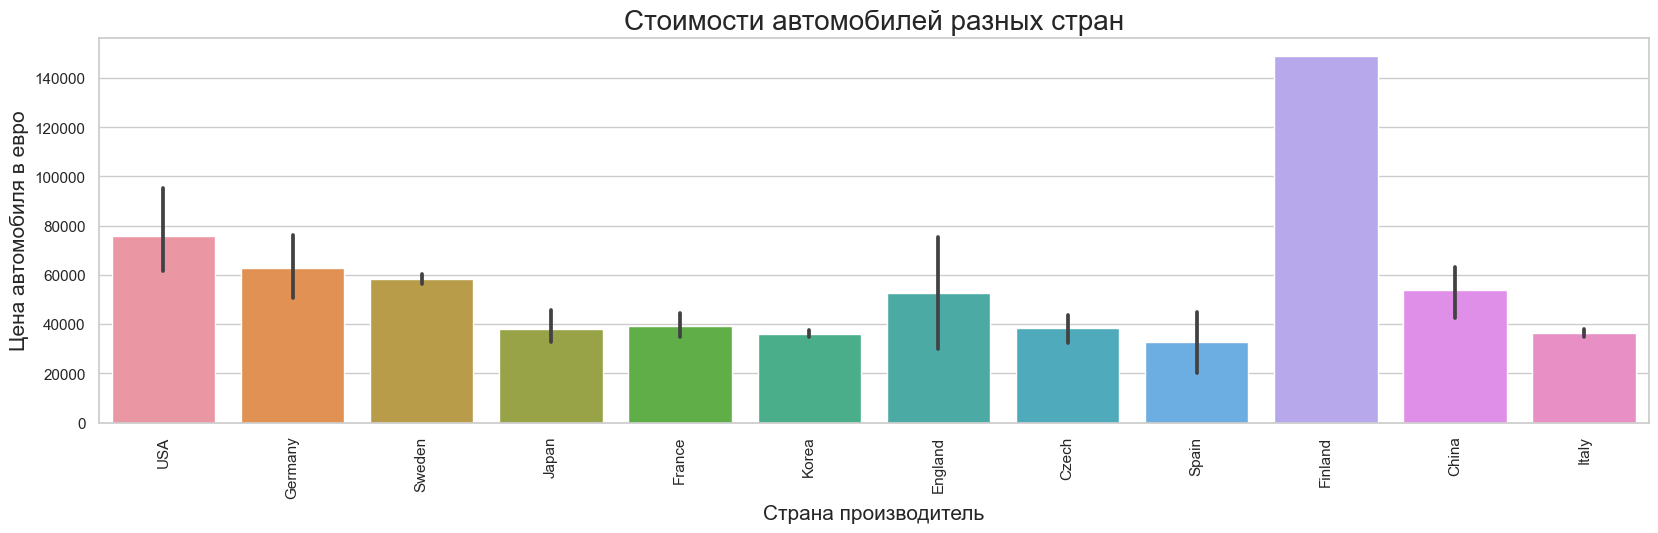

In [17]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "OriginCountry", y = "PriceEuro", data = df)
plt.title('Стоимости автомобилей разных стран', fontsize = 20)
plt.ylabel('Цена автомобиля в евро', fontsize= 15)
plt.xlabel('Страна производитель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Несмотря на то, что Финляндия производит меньше всего электрических автомобилей, их машины имеют самую высокую цену. США и Германия, производящие наибольшое число электрических автомобилей, имеют цену выше средней.

Запомним признак **OriginCountry**.

### Количественный признак Accel

Выясним, какой тип имеет признак **Accel** в датасете:

In [18]:
df['Accel'].describe()

count         103
unique         55
top       9.0 sec
freq            7
Name: Accel, dtype: object

Видим, что признак **Ускорение** принимает 55 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения числа с плавающей точкой плюс строка "sec.". Удалим строку ".sec" и уточним тип этого признака:

In [19]:
df['Accel'] = df['Accel'].apply(lambda x: x.replace( "sec", "")).astype('float64')
df['Accel'].describe()

count    103.000000
mean       7.396117
std        3.017430
min        2.100000
25%        5.100000
50%        7.300000
75%        9.000000
max       22.400000
Name: Accel, dtype: float64

Рассмотрим графики зависимости ускорения автомобиля от страны производителя и стоимости:

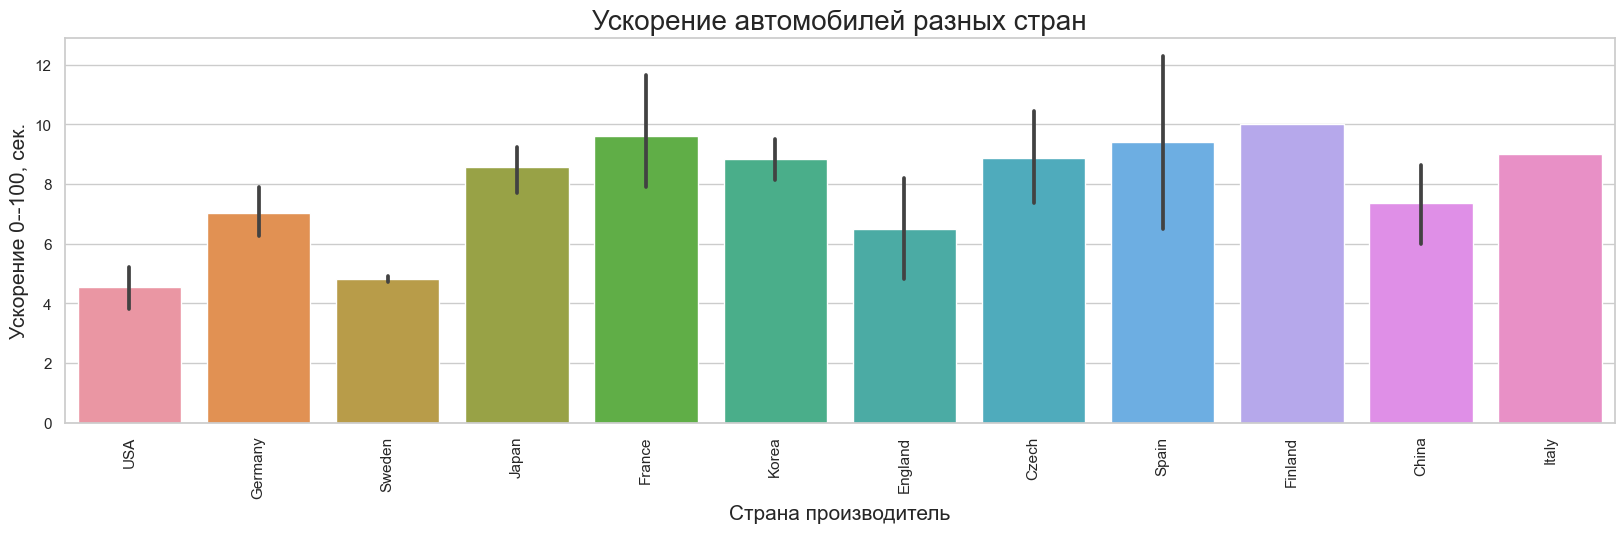

In [20]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "OriginCountry", y = "Accel", data = df)
plt.title('Ускорение автомобилей разных стран', fontsize = 20)
plt.ylabel('Ускорение 0--100, сек.', fontsize= 15)
plt.xlabel('Страна производитель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

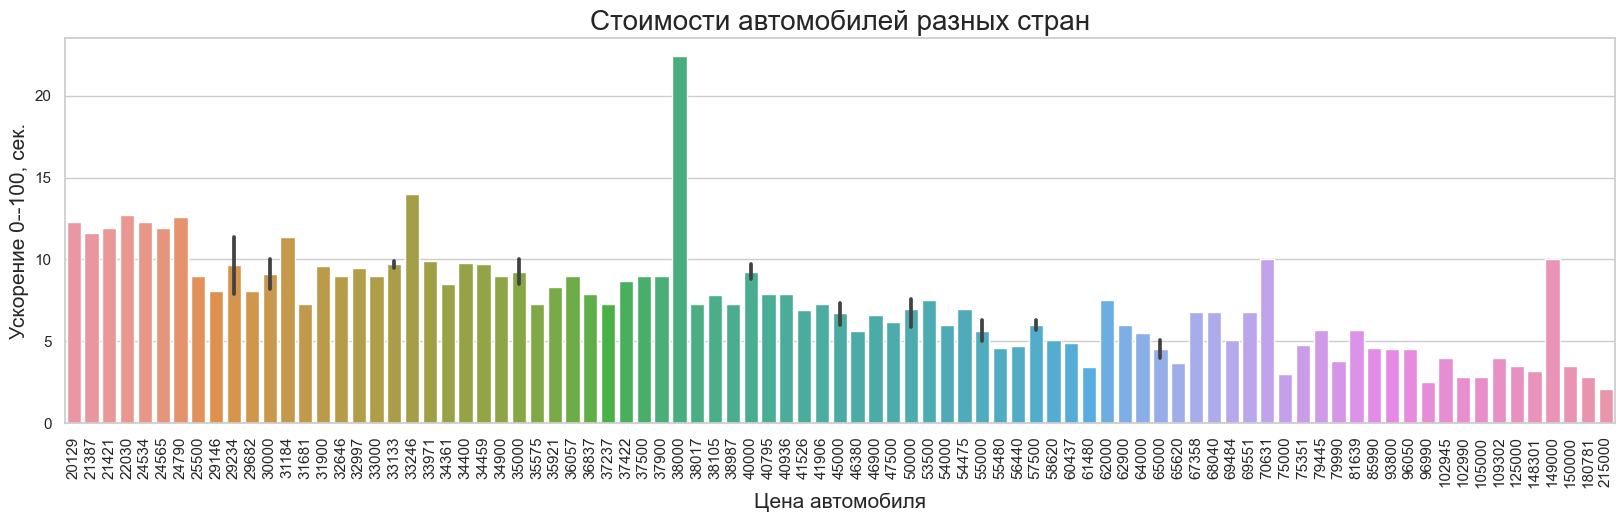

In [21]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "PriceEuro", y = "Accel", data = df)
plt.title('Стоимости автомобилей разных стран', fontsize = 20)
plt.ylabel('Ускорение 0--100, сек.', fontsize= 15)
plt.xlabel('Цена автомобиля', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Видим, что автомобили, быстрее всего выполяющие разгон 0--100, производятся в США. Самые медленный автомобили --- во Франции, Испании и Финляндии. Также видим тенденцию уменьшения разгоны 0--100 с увеличением цены автомобиля. Однако есть и исключения (например, автомобиль за 38000). Большинство автомобилей дороже 55000 евро разгоняются 0--100 меньше, чем за 5 секунд.

### Количественный признак TopSpeed

Выясним, какой тип имеет признак **TopSpeed** в датасете:

In [22]:
df['TopSpeed'].describe()

count          103
unique          25
top       160 km/h
freq            15
Name: TopSpeed, dtype: object

Видим, что признак **Максимальная скорость** принимает 25 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "km/h". Удалим строку "km/h" и уточним тип этого признака:

In [23]:
df['TopSpeed'] = df['TopSpeed'].apply(lambda x: x.replace( " km/h", "")).astype('int64')
df['TopSpeed'].describe()

count    103.000000
mean     179.194175
std       43.573030
min      123.000000
25%      150.000000
50%      160.000000
75%      200.000000
max      410.000000
Name: TopSpeed, dtype: float64

Рассмотрим графики зависимости максимальной скорости автомобиля от страны производителя и стоимости:

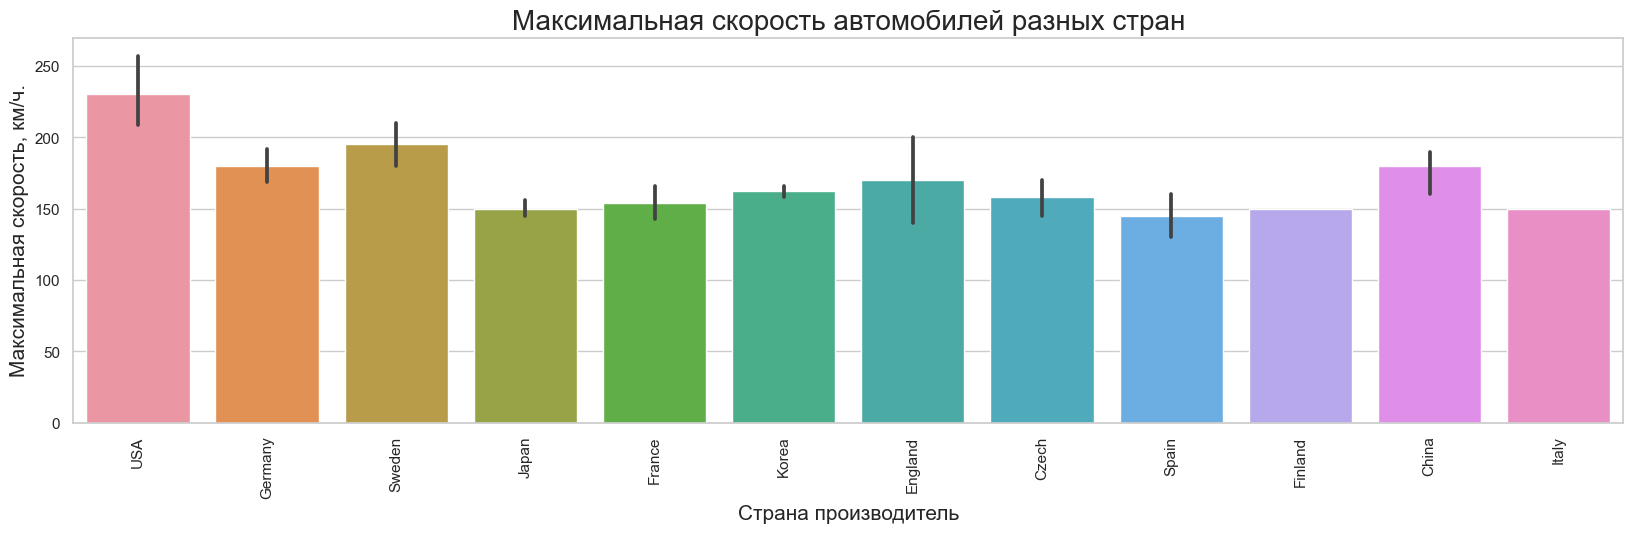

In [49]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "OriginCountry", y = "TopSpeed", data = df)
plt.title('Максимальная скорость автомобилей разных стран', fontsize = 20)
plt.ylabel('Максимальная скорость, км/ч.', fontsize= 15)
plt.xlabel('Страна производитель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

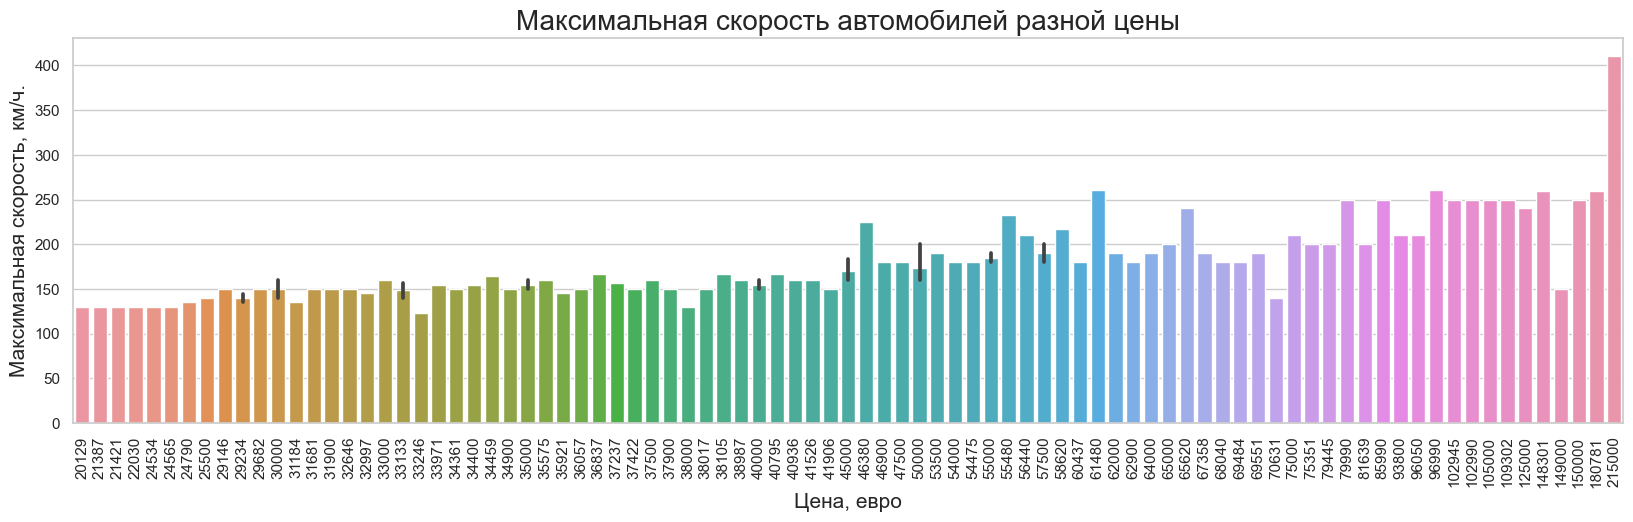

In [50]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "PriceEuro", y = "TopSpeed", data = df)
plt.title('Максимальная скорость автомобилей разной цены', fontsize = 20)
plt.ylabel('Максимальная скорость, км/ч.', fontsize= 15)
plt.xlabel('Цена, евро', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Видим, что автомобили, набирающие наибольшую максимальную скорость, производятся в США. Многие автомобили из других стран обладают примерно одинаковой максимальной скоростью, равной 150-170 км/ч. Также можно сделать вывод, что с увеличением стоимости автомобиля увеливается и его максимальная скорость. Многие автомобили дешевле 75000 евро не могут разогнаться до 200 км/ч.

### Количественный признак Range

Выясним, какой тип имеет признак **Range** в датасете:

In [55]:
df['Range'].describe()

count        103
unique        50
top       250 km
freq           6
Name: Range, dtype: object

Видим, что признак **Запас хода** принимает 50 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "km". Удалим строку "km" и уточним тип этого признака:

In [56]:
df['Range'] = df['Range'].apply(lambda x: x.replace( " km", "")).astype('int64')
df['Range'].describe()

count    103.000000
mean     338.786408
std      126.014444
min       95.000000
25%      250.000000
50%      340.000000
75%      400.000000
max      970.000000
Name: Range, dtype: float64

Рассмотрим графики зависимости запаса хода автомобиля от страны производителя и стоимости:

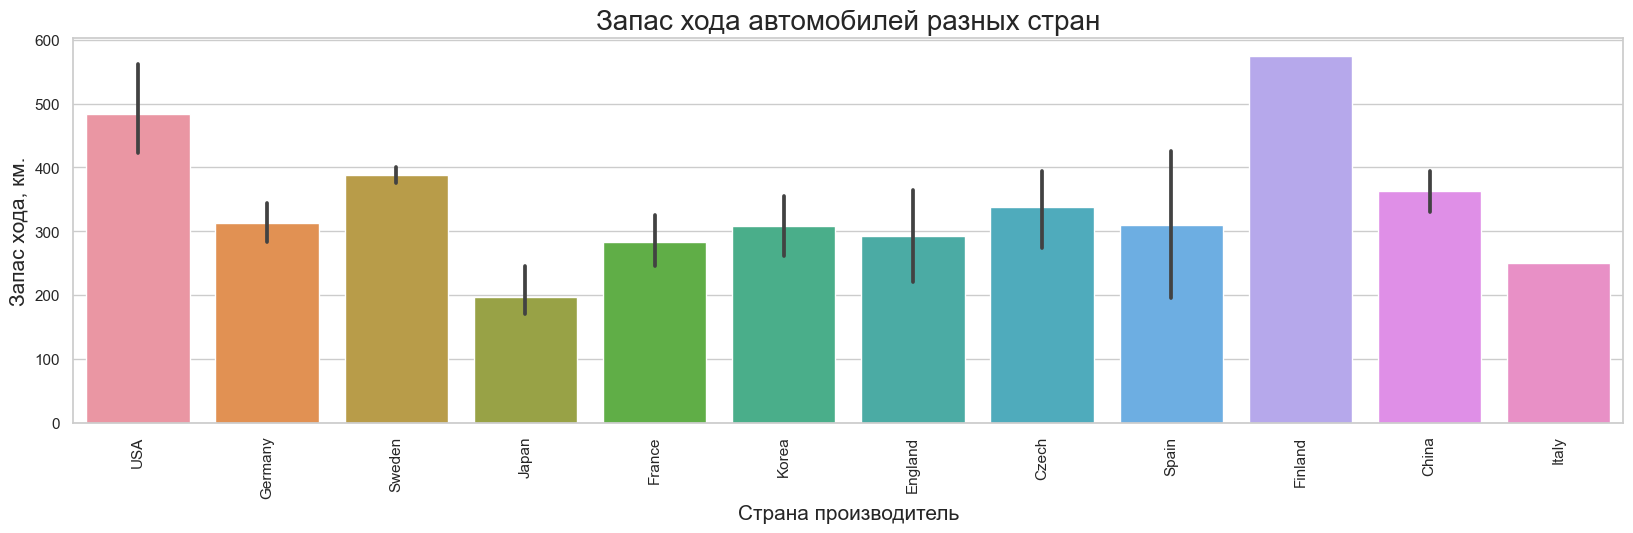

In [57]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "OriginCountry", y = "Range", data = df)
plt.title('Запас хода автомобилей разных стран', fontsize = 20)
plt.ylabel('Запас хода, км.', fontsize= 15)
plt.xlabel('Страна производитель', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

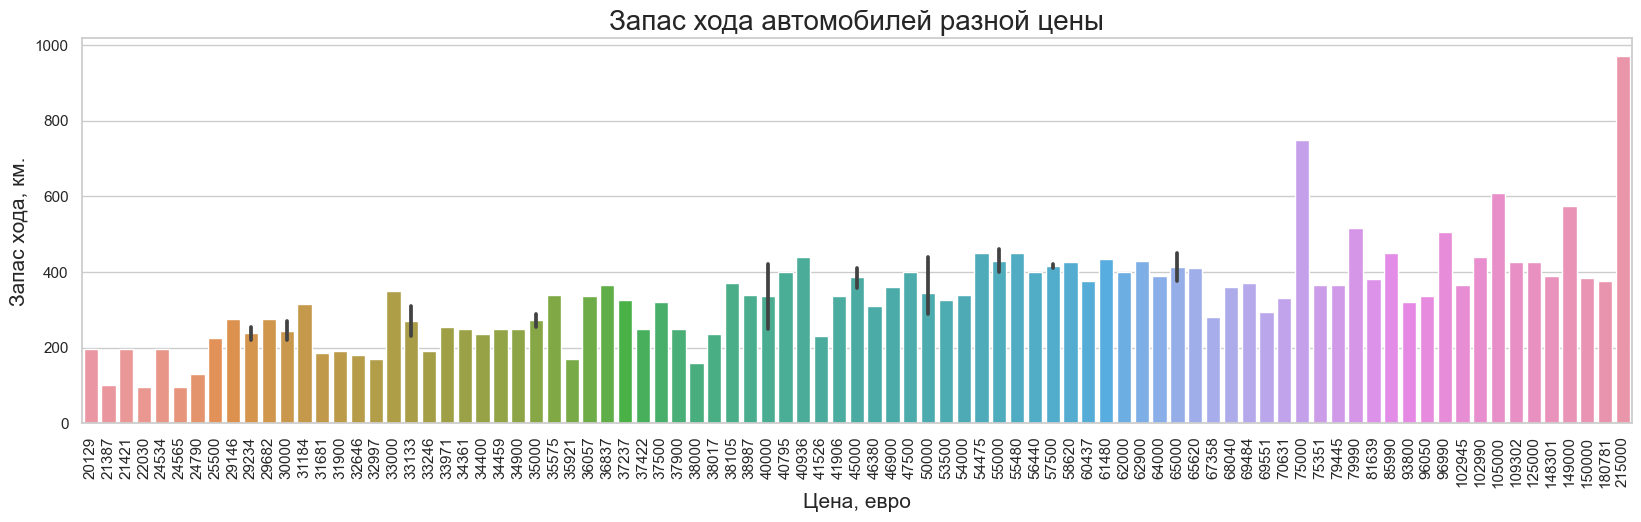

In [58]:
plt.figure(figsize=(20,5))
sns.set_theme(style="whitegrid")
sns.barplot(x = "PriceEuro", y = "Range", data = df)
plt.title('Запас хода автомобилей разной цены', fontsize = 20)
plt.ylabel('Запас хода, км.', fontsize= 15)
plt.xlabel('Цена, евро', fontsize= 15)
plt.xticks(rotation = 90)
plt.show()

Видим, что автомобили, набирающие наибольшую максимальную скорость, производятся в США и Франции. Самый маленький запас хода имеют автомобили из Японии. Также можно сделать вывод, что с увеличением стоимости автомобиля увеливается и его максимальный запас хода. Однако многие автомобили дешевле 55000 евро обладают запасом хода меньше 400 км. Автомобили в бюджете выше 55000 евро имеют средний запас хода 400 км.